# Experiments

These notebook is intended to retrieve the data from the experiments data contained in the CSV files that are generated automatically. It assumes some naming convention for the files that the user has to follow manually. The next cell contains all the code necessary for any experiment.

In [118]:
##
## MODULES
##

from matplotlib import pyplot as plt
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import os

##
## GLOBAL VARIABLES
## 

contexts_file = "contexts.txt"
results_folder = "results"
images_folder = "images"

results_columns = [
    "TraditionalSceneRenderTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
    "AddedTraditionalObjects",
    "AddedIndirectObjects",
    "ChunksLoaded",
    "ObjectPlacesGenerated",
]

time_columns = [
    "TraditionalSceneRenderTime",
    "IndirectObjectBatchBuildTime",
    "IndirectDrawBatchBuildTime",
    "IndirectShaderBatchBuildTime",
    "IndirectObjectBufferRefreshTime",
    "IndirectObjectHandleBufferRefreshTime",
    "IndirectMaterialBufferRefreshTime",
    "IndirectIndirectBufferRefreshTime",
    "IndirectSceneRenderTime",
    "DataGenerationTime",
    "TerrainRenderTime",
    "ObjectsPlacesGenerationTime",
]

##
## GLOBAL FUNCTIONS
##

def get_contexts():
    file_path = os.path.join('contexts.txt')
    contexts = []
    
    with open(file_path, 'r') as file:
        content = file.read().strip().split('@@@@@@@@')
        
        for context in content:
            if len(context) == 0:
                continue
            
            context_dict = {}
            
            for line in context.split('\n'):
                if line.strip():
                    key, value = line.split(':', 1)
                    context_dict[key.strip()] = value.strip()
                    
            contexts.append(context_dict)
            
    return contexts

def get_results(contexts):
    for context in contexts:
        result_path = context.get("ResultPath")
        if result_path and os.path.exists(result_path):
            context["Result"] = pd.read_csv(result_path)
            context["Result"].columns = results_columns
        else:
            context["Result"] = None  # Handle missing or invalid paths
    return contexts

def cast_int_contexts(contexts, key):
    for context in contexts:
        context[key] = int(context[key])
    

def filter_contexts(contexts, key, value):
    filtered_contexts = []
    
    for context in contexts:
        if context[key] == value:
            filtered_contexts.append(context)
            
    return filtered_contexts
    

def get_merged_contexts_results(contexts, merge_column_name):
    dataframes = []

    for context in contexts:
        context["Result"][merge_column_name] = context[merge_column_name]
        dataframes.append(context["Result"])

    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df = merged_df[[merge_column_name] + results_columns]
    
    return merged_df

def get_mili_times_df(df):
    for col in time_columns:
        if col in df.columns:
            df[col] = (df[col] / 1000).round(2)

def add_sum_column(df, column_name, columns_to_sum):
    df[column_name] = df[columns_to_sum].sum(axis=1)
    return df

def add_division_denominator_column(df, column_name, enumerator, denominator_column):
    df[column_name] = (enumerator / df[denominator_column])

def save_df_as_image(df, filename):
    fig, ax = plt.subplots(figsize=(10, 4))  # Set size frame
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    
##
## GLOBAL LOGIC
##

contexts = get_contexts()

get_results(contexts)


[{'Device': 'NVIDIA GeForce GTX 1660/PCIe/SSE2',
  'Experiment': 'Objects',
  'NumberOfChangingMaterialObjects': '0',
  'NumberOfChangingMaterialTypeObjects': '0',
  'NumberOfChangingMeshObjects': '0',
  'NumberOfChangingTransformObjects': '0',
  'NumberOfObjects': '32768',
  'ObjectRenderingMethod': 'Indirect',
  'ResultPath': 'C:/Users/juani/Desktop/Bachelor Thesis/Lotus-Engine/experiments/results/3bgbXcZi2MXc.csv',
  'TerrainRenderingMethod': 'Traditional',
  'Vendor': 'NVIDIA Corporation',
  'Result':      TraditionalSceneRenderTime  IndirectObjectBatchBuildTime  \
  0                             0                          7365   
  1                             0                             0   
  2                             0                             0   
  3                             0                             0   
  4                             0                             0   
  ..                          ...                           ...   
  994                 

## Objects

Average statistics per frame when running an application with a permanent amount of objects

In [119]:
experiment = "Objects"

experiment_contexts = filter_contexts(contexts, "Experiment", experiment)

cast_int_contexts(experiment_contexts, "NumberOfObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingTransformObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMeshObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialObjects")
cast_int_contexts(experiment_contexts, "NumberOfChangingMaterialTypeObjects")

### No Changing Objects

Experiments with an static amount of objects that don't suffer any type of change

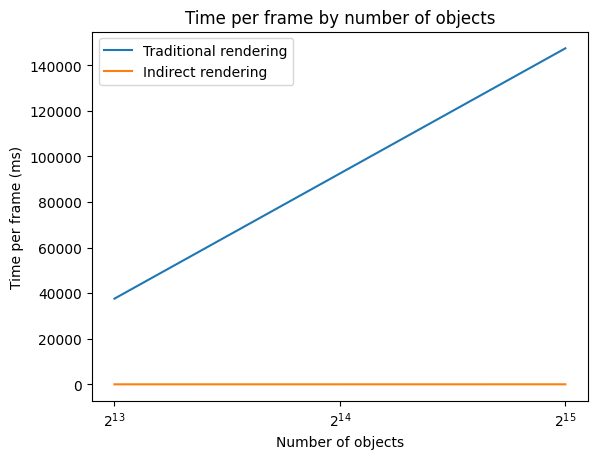

In [120]:
no_changing_contexts = filter_contexts(experiment_contexts, "NumberOfChangingTransformObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMeshObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialObjects", 0)
no_changing_contexts = filter_contexts(no_changing_contexts, "NumberOfChangingMaterialTypeObjects", 0)

no_changing_traditional_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Traditional")
no_changing_indirect_contexts = filter_contexts(no_changing_contexts, "ObjectRenderingMethod", "Indirect")


no_changing_traditional_results = get_merged_contexts_results(no_changing_traditional_contexts, "NumberOfObjects")
no_changing_indirect_results = get_merged_contexts_results(no_changing_indirect_contexts, "NumberOfObjects")

traditional_avg = no_changing_traditional_results.groupby("NumberOfObjects").mean()
indirect_avg = no_changing_indirect_results.groupby("NumberOfObjects").mean()

#get_mili_times_df(traditional_avg)
#get_mili_times_df(indirect_avg)

add_sum_column(traditional_avg, "FrameTime", ["TraditionalSceneRenderTime"])
add_division_denominator_column(traditional_avg, "FPS", 1_000_000, "FrameTime")

add_sum_column(indirect_avg, "BatchBuildTime", ["IndirectObjectBatchBuildTime", "IndirectDrawBatchBuildTime", "IndirectShaderBatchBuildTime"])
add_sum_column(indirect_avg, "BufferRefreshTime", ["IndirectObjectBufferRefreshTime", "IndirectObjectHandleBufferRefreshTime", "IndirectMaterialBufferRefreshTime", "IndirectIndirectBufferRefreshTime"])
add_sum_column(indirect_avg, "FrameTime", ["BatchBuildTime", "BufferRefreshTime", "IndirectSceneRenderTime"])
add_division_denominator_column(indirect_avg, "FPS", 1_000_000, "FrameTime")

fig, ax = plt.subplots()

ax.plot(traditional_avg.index, traditional_avg["FrameTime"], label="Traditional rendering")
ax.plot(indirect_avg.index, indirect_avg["FrameTime"], label="Indirect rendering")
ax.set_xscale('log', base=2)

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Time per frame (ms)")
ax.legend()
plt.title("Time per frame by number of objects")

# Save and show the plot
plt.savefig(images_folder + "/" + experiment + "-FrameTime-Line.png")
plt.show()



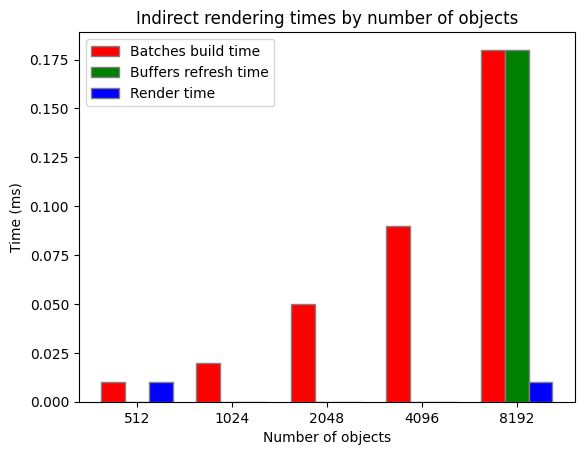

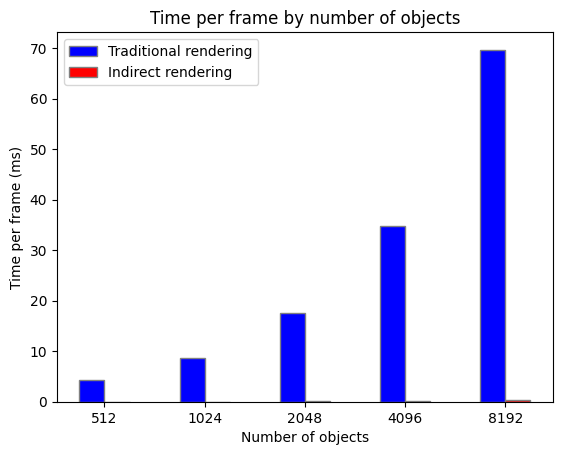

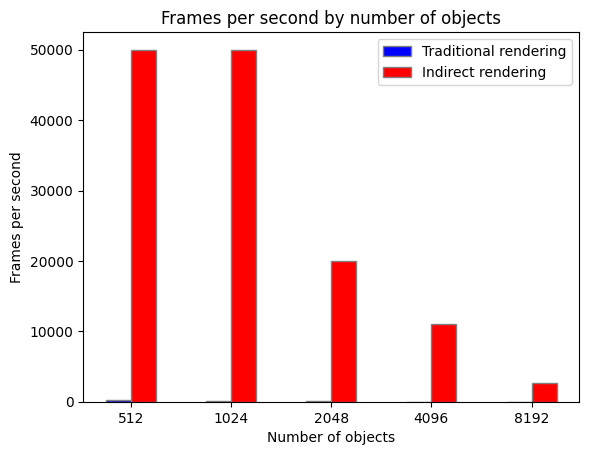

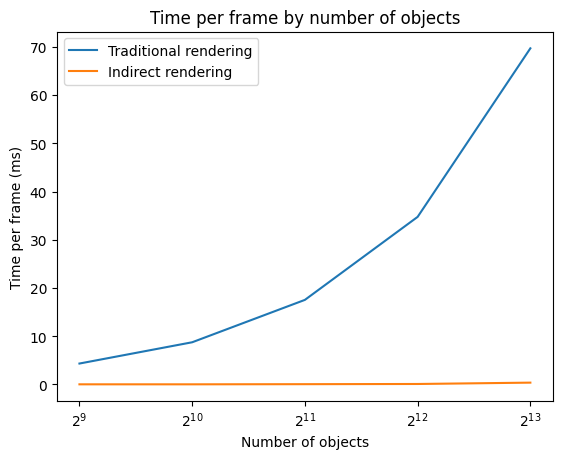

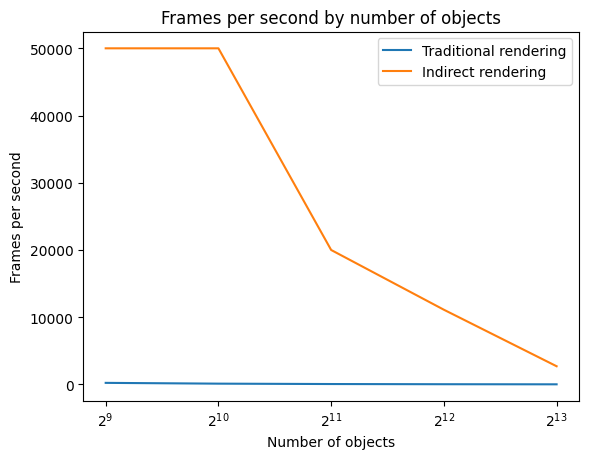

In [56]:
##
## INDIRECT INFORMATION
##

N_values = indirect_avg.index
batch_build_times = indirect_avg["BatchBuildTime"]
buffer_refresh_times = indirect_avg["BufferRefreshTime"]
indirect_scene_render_times = indirect_avg["IndirectSceneRenderTime"]

bar_width = 0.25
bar1 = np.arange(len(N_values))
bar2 = [x + bar_width for x in bar1]
bar3 = [x + bar_width for x in bar2]

plt.bar(bar1, batch_build_times, color='r', width=bar_width, edgecolor='grey', label="Batches build time")
plt.bar(bar2, buffer_refresh_times, color='g', width=bar_width, edgecolor='grey', label="Buffers refresh time")
plt.bar(bar3, indirect_scene_render_times, color='b', width=bar_width, edgecolor='grey', label="Render time")

# Set labels and title
plt.xlabel("Number of objects")
plt.ylabel("Time (ms)")
plt.title("Indirect rendering times by number of objects")
plt.xticks([r + bar_width for r in range(len(N_values))], N_values)
plt.legend()

# Save and show the plot
plt.savefig(images_folder + "/" + experiment + "-IndirectTimes-Bar.png")
plt.show()

##
## TABLES
##

#display(HTML(traditional_avg.to_html()))
#display(HTML(indirect_avg.to_html()))

##
## BAR FRAME TIME PLOT
##

bar_width = 0.25
bar1 = np.arange(len(traditional_avg.index))
bar2 = [x + bar_width for x in bar1]

# Frame Time Bar Chart
fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FrameTime"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FrameTime"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Time per frame (ms)")
ax.set_title("Time per frame by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()

# Save and show the plot
plt.savefig(f"{images_folder}/{experiment}-FrameTime-Bar.png")
plt.show()

##
## BAR FPS PLOT
##

fig, ax = plt.subplots()

ax.bar(bar1, traditional_avg["FPS"], color='b', width=bar_width, edgecolor='grey', label='Traditional rendering')
ax.bar(bar2, indirect_avg["FPS"], color='r', width=bar_width, edgecolor='grey', label='Indirect rendering')

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Frames per second")
ax.set_title("Frames per second by number of objects")
ax.set_xticks([r + bar_width / 2 for r in range(len(traditional_avg.index))])
ax.set_xticklabels(traditional_avg.index)
ax.legend()

# Save and show the plot
plt.savefig(f"{images_folder}/{experiment}-FPS-Bar.png")
plt.show()

##
## LINE FRAME TIME PLOT
##

fig, ax = plt.subplots()

ax.plot(traditional_avg.index, traditional_avg["FrameTime"], label="Traditional rendering")
ax.plot(indirect_avg.index, indirect_avg["FrameTime"], label="Indirect rendering")
ax.set_xscale('log', base=2)

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Time per frame (ms)")
ax.legend()
plt.title("Time per frame by number of objects")

# Save and show the plot
plt.savefig(images_folder + "/" + experiment + "-FrameTime-Line.png")
plt.show()

##
## LINE FPS PLOT
##

fig, ax = plt.subplots()

ax.plot(traditional_avg.index, traditional_avg["FPS"], label="Traditional rendering")
ax.plot(indirect_avg.index, indirect_avg["FPS"], label="Indirect rendering")
ax.set_xscale('log', base=2)

# Set labels and title
ax.set_xlabel("Number of objects")
ax.set_ylabel("Frames per second")
ax.legend()
plt.title("Frames per second by number of objects")

# Save and show the plot
plt.savefig(images_folder + "/" + experiment + "-FPS-Line.png")
plt.show()